# Import

In [47]:
%matplotlib inline
import joblib
from time import time
from pprint import pprint
import string

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer, TfidfTransformer
from sklearn.linear_model import SGDClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn import metrics

from sklearn.feature_extraction import stop_words
from nltk.corpus import stopwords
import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English
import nltk
from nltk.stem.porter import PorterStemmer 
from nltk.stem.snowball import SnowballStemmer
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
from nltk.stem.porter import *
import re

import warnings
warnings.filterwarnings("ignore")

In [16]:
train_data = pd.read_csv('dataset/train.csv')
train_data.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [17]:
test_data = pd.read_csv('dataset/test.csv')
y_test_data = pd.read_csv('dataset/sample_submission.csv')
test_data['target'] = y_test_data['target']
test_data.sample(10)

,id,keyword,location,text,target
1648,5550,flattened,"Hermiston, Oregon",I see a flattened Cyberman. Do I watch way too...,0
2014,6778,lightning,"Rotterdam, The Netherlands",@LtDalius after democracy,0
1612,5434,first%20responders,"Baton Rouge, LA",'The longer you wait the more people die': #La...,0
730,2378,collapsed,NaN,I collapsed in the bathroom bcuz of Michael.,0
823,2710,crushed,"NoPa, San Francisco",@AmyRamponi But theyÛªre not crushed? It does...,0
1007,3316,demolished,NaN,I got my wisdom teeth out yesterday and I just...,0
2213,7396,obliterated,England,@KoscielnyFC Gabriel obliterated his fibula,0
2545,8488,screamed,"Atlanta, GA (kind of)",@TroyLWiggins I screamed,0
2388,7985,razed,California,ABC News The Latest: More Homes Razed by North...,0
2136,7151,mudslide,Kocaeli-Izmit,#Tajikistan #Mudslides #China aids to #Mudslid...,0


In [18]:
y_test_data.target.value_counts()

0    3263
Name: target, dtype: int64

# preprocessing
## prep fucntions

In [70]:
def remove_punctuation(text):
    translator = str.maketrans('', '', string.punctuation)
    return text.translate(translator)


def remove_URL(text):
    url = re.compile(r'https?://\S+|www\.\S+')
    return url.sub(r'',text)

def remove_html(text):
    html=re.compile(r'<.*?>')
    return html.sub(r'',text)

def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

stemmer = SnowballStemmer("english")

def stemming(text):    
    '''a function which stems each word in the given text'''
    text = [stemmer.stem(word) for word in text.split()]
    return " ".join(text)

## Start preprocessing

In [52]:
train_data["text"] = train_data["text"].apply(remove_punctuation)
train_data["text"] = train_data["text"].apply(lambda x : remove_URL(x))
train_data["text"] = train_data["text"].apply(lambda x : remove_html(x))
train_data["text"] = train_data["text"].apply(lambda x : remove_emoji(x))

test_data["text"] = test_data["text"].apply(remove_punctuation)
test_data["text"] = test_data["text"].apply(lambda x : remove_URL(x))
test_data["text"] = test_data["text"].apply(lambda x : remove_html(x))
test_data["text"] = test_data["text"].apply(lambda x : remove_emoji(x))




test_data.dropna(how='any',inplace=True,axis=1)
train_data.dropna(how='any',inplace=True,axis=1)

In [73]:
train_data["text"] = train_data["text"].apply(stemming)
test_data["text"] = test_data["text"].apply(stemming)


In [74]:
train_data.head()

,id,text,target
0,1,our deed are the reason of this earthquak may ...,1
1,4,forest fire near la rong sask canada,1
2,5,all resid ask to shelter in place are be notif...,1
3,6,13000 peopl receiv wildfir evacu order in cali...,1
4,7,just got sent this photo from rubi alaska as s...,1


In [24]:
test_data.head()

,id,text,target
0,0,Just happened a terrible car crash,0
1,2,Heard about earthquake is different cities sta...,0
2,3,there is a forest fire at spot pond geese are ...,0
3,9,Apocalypse lighting Spokane wildfires,0
4,11,Typhoon Soudelor kills 28 in China and Taiwan,0


# WordCloud

In [75]:
def extraire_mots(df, target):
    liste=[]
    
    for x in df[df['target']==target]['text'].str.split():
        for i in x:
            liste.append(i)
    return liste

In [76]:
train_liste_mots_Disaster = extraire_mots(train_data, 1)
train_liste_mots_NoDisaster = extraire_mots(train_data, 0)

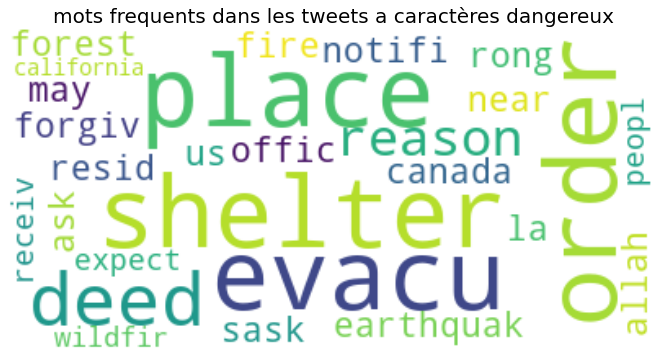

In [77]:
plt.figure(figsize=(14,6))
word_cloud = WordCloud(background_color="white",max_font_size=60).generate(" ".join(train_liste_mots_Disaster[:50]))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('mots frequents dans les tweets a caractères dangereux',fontsize=20)
plt.show()

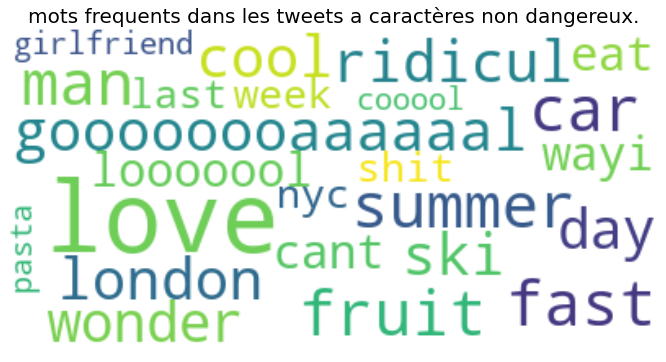

In [78]:
plt.figure(figsize=(14,6))
word_cloud = WordCloud(background_color="white",max_font_size=60).generate(" ".join(train_liste_mots_NoDisaster[:50]))
plt.imshow(word_cloud,interpolation='bilinear')
plt.axis('off')
plt.title('mots frequents dans les tweets a caractères non dangereux.',fontsize=20)
plt.show()

In [79]:
print('les ponctuations à enlever:\n\n\t', string.punctuation)

les ponctuations à enlever:

	 !"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


In [80]:
marks = string.punctuation
marks = list(marks)
marks.append("...")
marks.append("....")



nlp = spacy.load('en_core_web_sm')
stop_words = list(STOP_WORDS)

In [81]:
len(stop_words)

326

In [91]:
p = "I am a great president"
def preprocessor(sentence):
    return stemming(remove_URL(remove_emoji(remove_html(remove_punctuation(sentence)))))
def tokenizer(sentence):
    doc = nlp(sentence)
    clean_tokens = []
    for token in doc:
        if token.lemma_ != '-PRON-':
            token = token.lemma_.lower().strip()
        else:
            token = token.lower_
        if token not in stop_words and token not in marks:
            clean_tokens.append(token)
    return clean_tokens
preprocessor(p)

'i am a great presid'

## create a B-O-W and a TF-IDF vector using the same tokenizer

In [92]:
bow_vector = CountVectorizer(preprocessor=preprocessor, tokenizer = tokenizer, ngram_range=(1,1))
tfidf_vector = TfidfVectorizer(preprocessor=preprocessor, tokenizer = tokenizer)

In [93]:
X = train_data['text']
y = train_data['target']

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.3, random_state=7)

# Train model

## pipeline with Random Forest 

In [94]:
classifier = RandomForestClassifier()

rf_pipe = Pipeline([('vectorizer', bow_vector),
                 ('classifier', classifier)])

rf_pipe.fit(X_train,y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(preprocessor=<function preprocessor at 0x0000022D9D4E4678>,
                                 tokenizer=<function tokenizer at 0x0000022D9D4E4C18>)),
                ('classifier', RandomForestClassifier())])

In [95]:
rf_pipe.score(X_val, y_val)

0.787215411558669

In [97]:
rf_pipe.predict([test_data['text'][0]])

array([0], dtype=int64)

In [100]:
joblib.dump(rf_pipe, 'model.joblib')

['model.joblib']

In [99]:
test_data['text'][0]

'just happen a terribl car crash'

In [87]:
classifier = LogisticRegression()

lr_pipe = Pipeline([('vectorizer', bow_vector),
                 ('classifier', classifier)])

lr_pipe.fit(X_train,y_train)

Pipeline(steps=[('vectorizer',
                 CountVectorizer(tokenizer=<function tokenizer at 0x0000022D99A20318>)),
                ('classifier', LogisticRegression())])

In [88]:
lr_pipe.score(X_val, y_val)

0.7950963222416813

In [89]:
lr_pipe.score(test_data['text'], test_data['target'])

0.6466441924609255

In [90]:
rf_pipe.score(test_data['text'], test_data['target'])

0.6929206251915415